<a href="https://colab.research.google.com/github/gwardasz/xai/blob/main/Tree_with_HS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [31]:
! pip install imodels -q

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imodels import HSTreeClassifierCV, HSTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [33]:
url = 'https://raw.githubusercontent.com/gwardasz/xai/refs/heads/main/recidivism.csv'
df = pd.read_csv(url)
employment_mapping = {'unemployed': 0, 'employed': 1}
df['employment'] = df['employment'].map(employment_mapping)

feature_cols = df.columns.values.tolist()[:-1]

X = df[feature_cols]
y = df.recid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
X_train, X_test, y_train, y_test = (x.to_numpy() for x in (X_train, X_test, y_train, y_test))


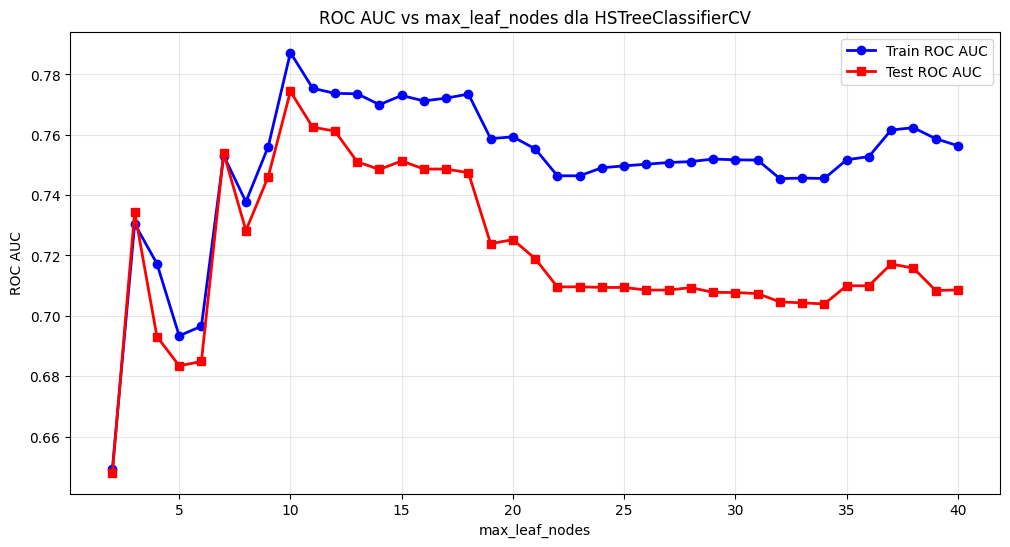

In [34]:
# Plot for different max_leaf_nodes values
max_leaf_nodes_values = range(2, 41)  # od 2 do 20
auc_scores_test = []
auc_scores_train = []

for max_leaf_nodes in max_leaf_nodes_values:
    model = HSTreeClassifierCV(max_leaf_nodes=max_leaf_nodes, random_state=42)
    model.fit(X_train, y_train, feature_names=feature_cols)
    preds_proba = model.predict_proba(X_test)

    # ROC AUC for test data
    preds_proba_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, preds_proba_test[:, 1])
    auc_scores_test.append(auc_test)

    # ROC AUC for train data
    preds_proba_train = model.predict_proba(X_train)
    auc_train = roc_auc_score(y_train, preds_proba_train[:, 1])
    auc_scores_train.append(auc_train)

    # print(f'max_leaf_nodes={max_leaf_nodes}, Train AUC={auc_train:.4f}, Test AUC={auc_test:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(max_leaf_nodes_values, auc_scores_train, marker='o', linewidth=2, markersize=6, label='Train ROC AUC', color='blue')
plt.plot(max_leaf_nodes_values, auc_scores_test, marker='s', linewidth=2, markersize=6, label='Test ROC AUC', color='red')
plt.xlabel('max_leaf_nodes')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs max_leaf_nodes dla HSTreeClassifierCV')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [35]:
model = HSTreeClassifierCV(max_leaf_nodes=5)
model.fit(X_train, y_train, feature_names=feature_cols)
preds = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, preds_proba[:, 1])
print(f'test mse: {np.mean(np.square(preds-y_test)):0.2f}')
print(f'AUC={auc:.4f}')
#print(model)
#print(model.get_params())

test mse: 0.31
AUC=0.6834


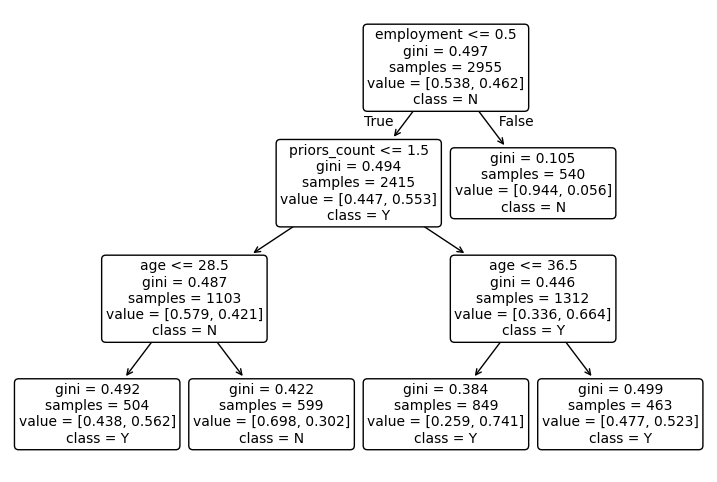

In [36]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,6))
_ = plot_tree(model.estimator_, feature_names=feature_cols, rounded=True, class_names=['N', 'Y'], fontsize=10, filled=True,)
plt.show()

To see the colours, we need to build a DecisionTreeClassifier without HS, as HS normalises the number of samples to a percentage probability.

In [37]:
from sklearn.tree import DecisionTreeClassifier

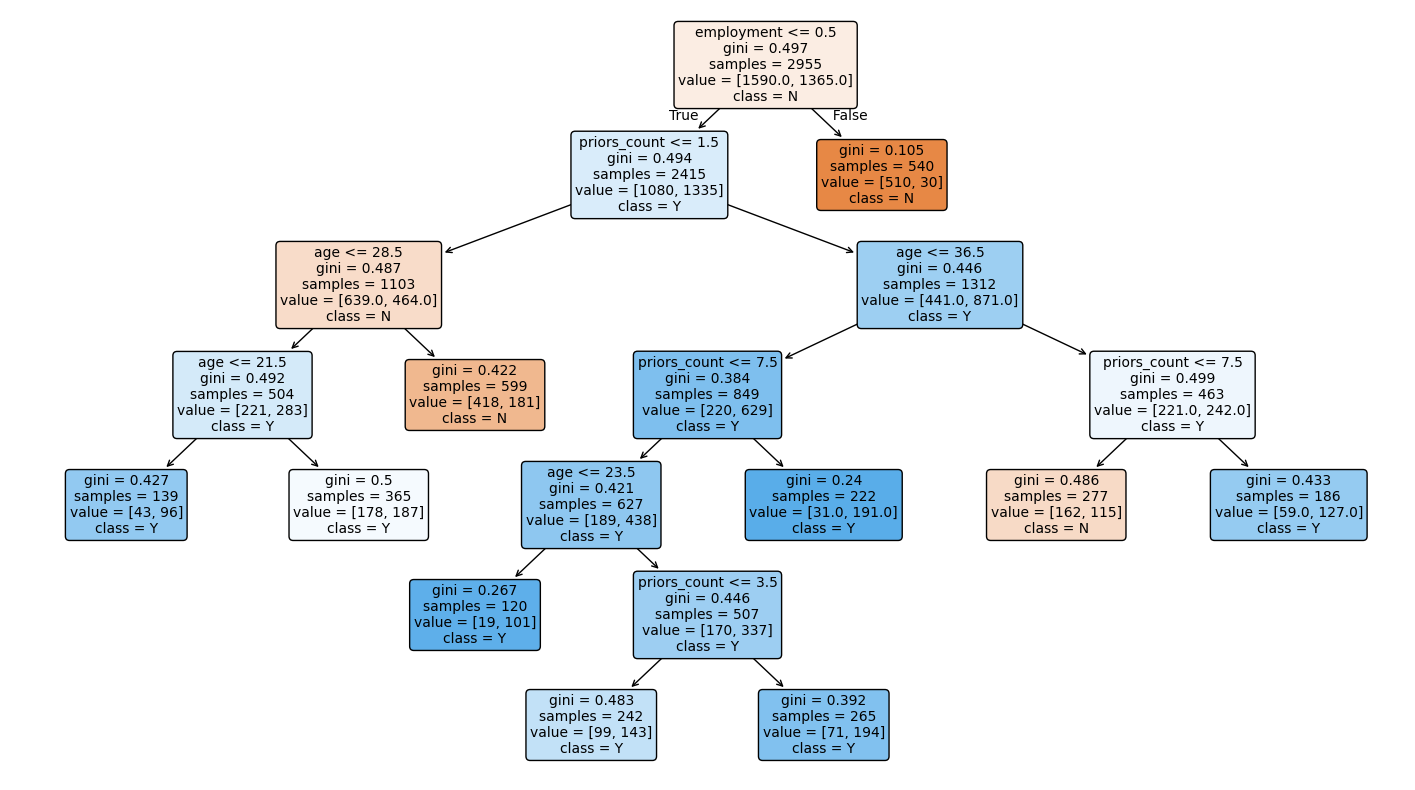

In [38]:
base_dt = DecisionTreeClassifier(max_leaf_nodes=10, random_state=411)
base_dt.fit(X_train, y_train)
plt.figure(figsize=(18,10))
plot_tree(base_dt,
          feature_names=feature_cols,
          class_names=['N','Y'],
          rounded=True,
          filled=True,
          fontsize=10)
plt.show()

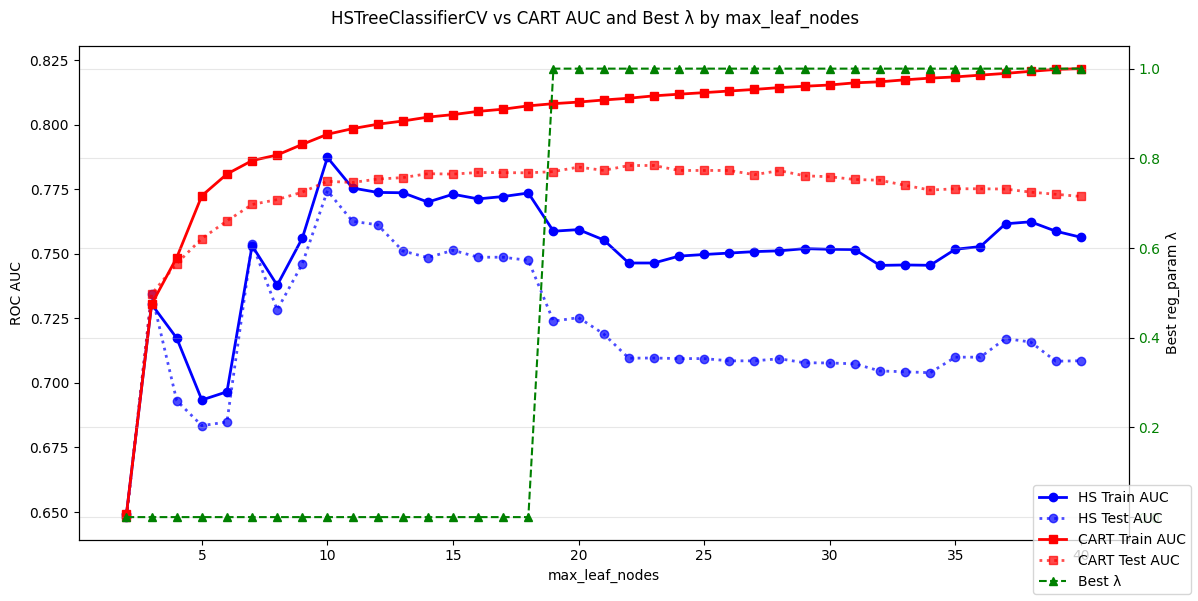

In [45]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from imodels import HSTreeClassifierCV
from sklearn.metrics import roc_auc_score

# Range of max_leaf_nodes values
max_leaf_nodes_values = range(2, 41)

# Initialize lists
auc_hs_train = []
auc_hs_test  = []
auc_dt_train = []
auc_dt_test  = []
best_lambdas = []

# Iterate over different max_leaf_nodes
for ml in max_leaf_nodes_values:
    # Hierarchical Shrinkage Tree
    hs = HSTreeClassifierCV(max_leaf_nodes=ml, random_state=4)
    hs.fit(X_train, y_train, feature_names=feature_cols)
    proba_train = hs.predict_proba(X_train)[:, 1]
    proba_test  = hs.predict_proba(X_test)[:, 1]
    auc_hs_train.append(roc_auc_score(y_train, proba_train))
    auc_hs_test.append( roc_auc_score(y_test,  proba_test))
    best_lambdas.append(hs.get_params()['reg_param'])

    # Standard CART
    dt = DecisionTreeClassifier(max_leaf_nodes=ml, random_state=4)
    dt.fit(X_train, y_train)
    proba_train_dt = dt.predict_proba(X_train)[:, 1]
    proba_test_dt  = dt.predict_proba(X_test)[:, 1]
    auc_dt_train.append(roc_auc_score(y_train, proba_train_dt))
    auc_dt_test.append( roc_auc_score(y_test,  proba_test_dt))

# Plot the results
fig, ax1 = plt.subplots(figsize=(12, 6))

# AUC curves
ax1.plot(max_leaf_nodes_values, auc_hs_train, marker='o', linestyle='-', linewidth=2, label='HS Train AUC', color='blue')
ax1.plot(max_leaf_nodes_values, auc_hs_test,  marker='o', linestyle=':', linewidth=2, label='HS Test AUC',  color='blue', alpha=0.7)
ax1.plot(max_leaf_nodes_values, auc_dt_train, marker='s', linestyle='-', linewidth=2, label='CART Train AUC', color='red')
ax1.plot(max_leaf_nodes_values, auc_dt_test,  marker='s', linestyle=':', linewidth=2, label='CART Test AUC',  color='red', alpha=0.7)

ax1.set_xlabel('max_leaf_nodes')
ax1.set_ylabel('ROC AUC')
ax1.tick_params(axis='y', labelcolor='black')

# Second axis for lambda (linear scale)
ax2 = ax1.twinx()
ax2.plot(max_leaf_nodes_values, best_lambdas, marker='^', linestyle='--', color='green', label='Best λ')
ax2.set_ylabel('Best reg_param λ', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Legends and grid
fig.suptitle('HSTreeClassifierCV vs CART AUC and Best λ by max_leaf_nodes')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [40]:
from imodels import HSTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import cross_validate
import numpy as np

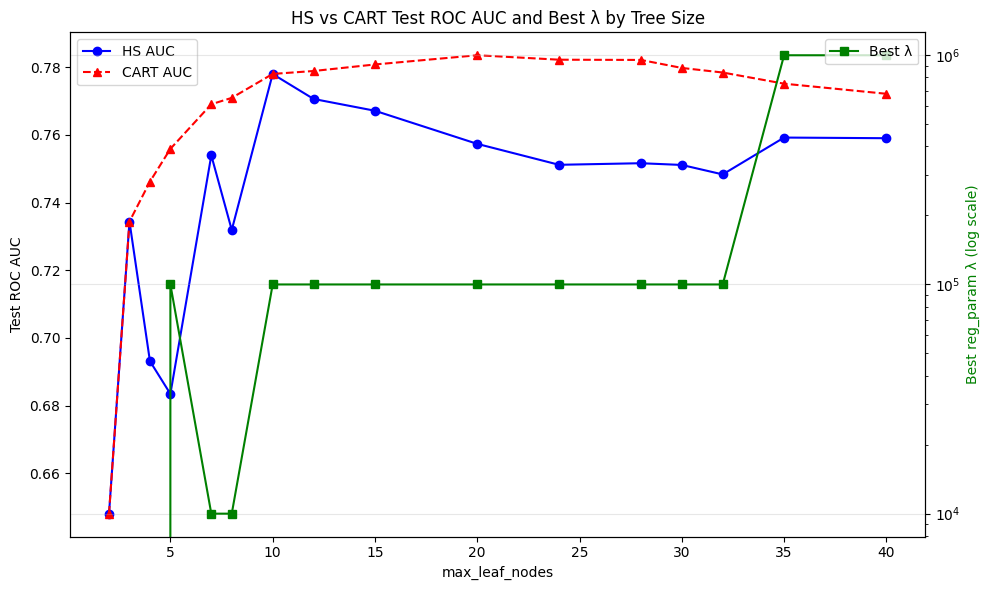

In [47]:
# Define parameter ranges
reg_params = [0, 0.1, 1.0, 10.0, 25.0, 50.0, 10e2, 10e3, 10e4, 10e5]
leaf_values = [2,3, 4, 5, 7, 8, 10, 12, 15, 20, 24, 28, 30, 32, 35, 40]

best_configs = []

# Grid search + hold-out evaluation
for m in leaf_values:
    # Cross-validate each reg_param
    cv_results = []
    for lam in reg_params:
        model = HSTreeClassifier(max_leaf_nodes=m, reg_param=lam, random_state=42)
        scores = cross_validate(
            model, X_train, y_train,
            cv=5,
            scoring='roc_auc',
            return_train_score=False
        )
        cv_results.append((lam, scores['test_score'].mean()))
    # Select best lambda
    best_lam, best_cv_auc = max(cv_results, key=lambda x: x[1])
    # Train and test best model
    best_model = HSTreeClassifier(max_leaf_nodes=m, reg_param=best_lam, random_state=42)
    best_model.fit(X_train, y_train)
    proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, proba)
    best_configs.append({
        'max_leaf_nodes': m,
        'best_lambda': best_lam,
        'cv_auc': best_cv_auc,
        'test_auc': test_auc
    })

# Prepare arrays
ms = [c['max_leaf_nodes'] for c in best_configs]
hs_aucs = [c['test_auc'] for c in best_configs]
lambdas = [c['best_lambda'] for c in best_configs]

# Compute CART baseline
cart_aucs = []
for m in ms:
    dt = DecisionTreeClassifier(max_leaf_nodes=m, random_state=42)
    dt.fit(X_train, y_train)
    proba = dt.predict_proba(X_test)[:, 1]
    cart_aucs.append(roc_auc_score(y_test, proba))

# Plot results
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(ms, hs_aucs, marker='o', color='blue', label='HS AUC')
ax1.plot(ms, cart_aucs, marker='^', linestyle='--', color='red', label='CART AUC')
ax1.set_xlabel('max_leaf_nodes')
ax1.set_ylabel('Test ROC AUC')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.plot(ms, lambdas, marker='s', color='green', label='Best λ')
ax2.set_ylabel('Best reg_param λ (log scale)', color='green')
ax2.legend(loc='upper right')

plt.title('HS vs CART Test ROC AUC and Best λ by Tree Size')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [42]:
# Define the best hyperparameters
best_max_leaf_nodes = 10
best_reg_param = 1e4

# Initialize the HSTreeClassifier with chosen parameters
model = HSTreeClassifier(
    max_leaf_nodes=best_max_leaf_nodes,
    reg_param=best_reg_param,
    random_state=42
)

print(model.get_params())


# Perform 5-fold cross-validation on the training set
cv_scores = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring=['roc_auc', 'accuracy'],
    return_train_score=True
)

# Extract CV metrics
train_auc_cv = cv_scores['train_roc_auc']
test_auc_cv  = cv_scores['test_roc_auc']
train_acc_cv = cv_scores['train_accuracy']
test_acc_cv  = cv_scores['test_accuracy']

# Print cross-validation results
print("=== HSTreeClassifier 5-Fold CV Results ===")
print(f"Parameters: max_leaf_nodes={best_max_leaf_nodes}, reg_param={best_reg_param}")
print(f"CV Train AUC:     {train_auc_cv.mean():.4f} ± {train_auc_cv.std():.4f}")
print(f"CV Test AUC:      {test_auc_cv.mean():.4f} ± {test_auc_cv.std():.4f}")
print(f"CV Train Accuracy:{train_acc_cv.mean():.4f} ± {train_acc_cv.std():.4f}")
print(f"CV Test Accuracy: {test_acc_cv.mean():.4f} ± {test_acc_cv.std():.4f}")
print(f"CV AUC Gap:       {train_auc_cv.mean() - test_auc_cv.mean():.4f}")

# Fit the model on the entire training set
model.fit(X_train, y_train)

train_preds  = model.predict(X_train)
train_proba  = model.predict_proba(X_train)
train_auc    = roc_auc_score(y_train, train_proba[:, 1])
train_acc    = accuracy_score(y_train, train_preds)

#Print train result
print("\n=== Final Train Set Results ===")
print(f"Train AUC:      {train_auc:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")


# Evaluate on the hold-out test set
final_test_preds  = model.predict(X_test)
final_test_proba  = model.predict_proba(X_test)[:, 1]
final_test_auc    = roc_auc_score(y_test, final_test_proba)
final_test_acc    = accuracy_score(y_test, final_test_preds)

# Print final test results
print("\n=== Final Test Set Results ===")
print(f"Test AUC:      {final_test_auc:.4f}")
print(f"Test Accuracy: {final_test_acc:.4f}")

# Optional: detailed classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, final_test_preds, target_names=['Class 0', 'Class 1']))

{'reg_param': 10000.0, 'estimator_': DecisionTreeClassifier(max_leaf_nodes=10, random_state=42), 'shrinkage_scheme_': 'node_based', 'max_leaf_nodes': 10}
=== HSTreeClassifier 5-Fold CV Results ===
Parameters: max_leaf_nodes=10, reg_param=10000.0
CV Train AUC:     0.7814 ± 0.0127
CV Test AUC:      0.7630 ± 0.0190
CV Train Accuracy:0.7168 ± 0.0043
CV Test Accuracy: 0.7056 ± 0.0144
CV AUC Gap:       0.0184

=== Final Train Set Results ===
Train AUC:      0.7897
Train Accuracy: 0.7174

=== Final Test Set Results ===
Test AUC:      0.7780
Test Accuracy: 0.6977

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.68      0.79      0.73       655
     Class 1       0.73      0.60      0.66       612

    accuracy                           0.70      1267
   macro avg       0.70      0.69      0.69      1267
weighted avg       0.70      0.70      0.69      1267

